We are going to implement a code for Linear Quadratic Control problem 

Loss function = $\dfrac1M\sum_{t=0}^{N-1}((aX_t^2+bX_t+Au_t^2+Bu_t)\delta_t+\alpha X_T^2+\beta X_T)$

where $\delta_t=\frac{N}{T}$

State Process $X_{t+1}=X_t+(cX_t+du_t)\delta_t+\sigma\delta_t\epsilon_t$

The HJB equation is given by

$0=\partial_t V(t,x)+\frac{\sigma^2}{2}\partial_x^2V(t,x) +cx\partial_xV(t,x)+ax^2+bx+\inf_u\Big[Au^2+\Big(B+d\partial_xV(t,x)\Big)u\Big]$

$V(T,x)=\alpha x^2+\beta x$.

The optimal solution solution obtained as
$u^*=-\frac{B+d\partial_xV(t,x)}{2A}$
depends on the value function $V(t,x)$, which is the solution of the following PDE
$0=\partial_t V(t,x)+\frac{\sigma^2}{2}\partial_x^2V(t,x) +cx\partial_xV(t,x)+ax^2+bx-\frac{\big(B+d\partial_xV(t,x)\big)^2}{4A}$

$V(T,x)=\alpha x^2+\beta x$.

In [16]:
import numpy as np
import time
from scipy import misc
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
font = font_manager.FontProperties(style='normal', size=20)
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import math
import pandas as pd
from scipy.optimize import fsolve
# from scipy.integrate import solve_ivp # type: ignore
import scipy.integrate as integrate

import json

from IPython.display import display, Math, Markdown


# Parameters

In [17]:
model_params = {
    'num_samples':100,
    'num_time_steps':20,
    'num_neurons_p':50,
    'num_neurons_v':10,
    'lr' : 8e-3,
    'num_epochs' : 3000,
    'xmin' : 0.,
    'xmax' : 1.,
    'intervals' : None # a list of numbers between 0 to num_intervals-1
    }
lqsc_params = {
    'T':1,
    'a':0.5,
    'b':0.5,
    'c':1,
    'd':0.5,
    'A':1,
    'B':1,
    'sigma':0.5,
    'alpha':0.5,
    'beta':0.5,
    'gamma':0.0
    }

# Function class

In [18]:
class func(object):
    def __init__(self, lqsc_params):
        self.alpha = lqsc_params['alpha']
        self.beta = lqsc_params['beta']
        self.gamma = lqsc_params['gamma']
        self.A = lqsc_params['A']
        self.B = lqsc_params['B']
        self.a = lqsc_params['a']
        self.b = lqsc_params['b']
        self.c = lqsc_params['c']
        self.d = lqsc_params['d']
        self.T = lqsc_params['T']
        self.sigma = lqsc_params['sigma']

    
class term(func):
    def __init__(self, lqsc_params): 
        super(term, self).__init__(lqsc_params)
        self.fnc = lambda tx: self.alpha*torch.pow(tx[:,1],2)+self.beta*tx[:,1]+self.gamma
    def __call__(self,tx):
            return self.fnc(tx)
        
class solution(func):
    def __init__(self, lqsc_params):
        super(solution, self).__init__(lqsc_params)
        q0=self.A
        q1=2*self.c
        q2 = -self.d**2/self.A
        lb1=0.5*(q1+np.sqrt(q1**2-4*q0*q2))
        lb2 = -lb1+q1
        C1 = -(lb1+q2*self.alpha)/(lb2+q2*self.alpha)
        C2 = self.beta*(1+C1)-self.b*(1/(lb1-self.c)+C1/(lb2-self.c))+self.B/self.d*(lb1/(lb1-self.c)+C1*lb2/(lb2-self.c))
        self.f_func = lambda t: -1/q2*(lb1*np.exp(lb1*(self.T-t))+C1*lb2*np.exp(lb2*(self.T-t)))/(np.exp(lb1*(self.T-t))+C1*np.exp(lb2*(self.T-t)))
        self.h_func = lambda t: (self.b*((1/(lb1-self.c))*np.exp(lb1*(self.T-t))+C1*(1/(lb2-self.c))*np.exp(lb2*(self.T-t)))-self.B/self.d*((lb1/(lb1-self.c))*np.exp(lb1*(self.T-t))+C1*(lb2/(lb2-self.c))*np.exp(lb2*(self.T-t)))+C2*np.exp(self.c*(self.T-t)))/(np.exp(lb1*(self.T-t))+C1*np.exp(lb2*(self.T-t)))
        self.integrand = lambda t: self.sigma**2*self.f_func(self.T-t) -(self.B+self.d*self.h_func(self.T-t))**2/(4*self.A)
        self.k_func = lambda t: integrate.quad(lambda x: self.integrand(x), 0, self.T-t)[0]     
    def __call__(self,tx):
            return np.array([self.f_func(tx[i,0])*np.power(tx[i,1],2)+self.h_func(tx[i,0])*tx[i,1]+self.k_func(tx[i,0]) for i in range(tx.shape[0])])
    def optimal_policy(self,tx):
            return np.array([2*self.f_func(tx[i,0])*tx[i,1]+self.h_func(tx[i,0]) for i in range(tx.shape[0])])      

In [19]:
t1 = term(lqsc_params)
input=torch.tensor([[0,1],[1,.2]])
t1(input)#,lqsc.loss_func_ter(input)

tensor([1.0000, 0.1200])

# Closed-from solution for LQSC

In [20]:
solution = solution(lqsc_params)

We assume that the value function is quadratic in $x$,

$V(t,x)=f(t)x^2+h(t)x+k(t)$. 

By substituting $V$ in the HJB PDE we get the following system of Riccati ODE.

$0=f'+a+2cf-\frac{d^2}{A}f^2;  f(T)=\alpha$

$0=h'+b-\frac{(B+dh)d}{A}f;  h(T)=\beta$

$0=k'+\sigma^2 f-\frac{1}{4A}(B+dh)^2;  k(T)=0$

By solving this system of first order ODE we can get $f,h,t$ in closed form and we obtain the optimal solution as

$u^*=-\frac{B+d(2xf(t)+h(t))}{2A}$

First let's write all equations forward and then change $t$ to $T-t$ at the end.

$f'=a+2cf-\frac{d^2}{A}f^2;  f(0)=\alpha$

$h'=b-\frac{(B+dh)d}{A}f;  h(0)=\beta$

$k'=\sigma^2 f-\frac{1}{4A}(B+dh)^2;  k(0)=0$

$f$ satisfies a Riccati ODE: $f(t)=-\dfrac{1}{q_2}\dfrac{\lambda_1 e^{\lambda_1 (T-t)}+C\lambda_2 e^{\lambda_2 (T-t)}}{ e^{\lambda_1 (T-t)}+C e^{\lambda_2 (T-t)}}$ with

$C=-\dfrac{\lambda_1+q_2\alpha}{\lambda_2+q_2\alpha}$, $q_2=-\dfrac{d^2}{A}$, $q_1=2c$, $q_0=a$, $\lambda_1=\dfrac{q_1+\sqrt{q_1^2-2q_0q_2}}{2}$, and $\lambda_2=\dfrac{q_1-\sqrt{q_1^2-2q_0q_2}}{2}$


We modify the $h$ ODE by:

$h'=b-\frac{Bd}{A}f-\frac{d^2}{A}fh = b-\frac{Bd}{A}f+q_2fh ;  h(0)=\beta$

$h'-q_2fh= b-\frac{Bd}{A}f$


$\left( e^{-q_2\int fdt}h\right)'= e^{-q_2\int fdt}(b-\frac{Bd}{A}f)$


In the process of finding $f$, we note that $f = -\dfrac{U'(t)}{q_2U(t)}$, where $U(t)=e^{\lambda_1 t}+Ce^{\lambda_2 t}$. Thus,

$-q_2\int f dt = \ln U(t)$ and $e^{-q_2\int fdt}=U(t)$.


$U(t) h(t) = \int U(t)(b-\frac{Bd}{A}f)dt = \int U(t)(b+\frac{Bd}{A}\dfrac{U'(t)}{q_2U(t)})dt= \int (U(t)b-\frac{B}{d}{U'(t)})dt$


$h(t) =  \dfrac{1}{U(t)}\int (U(t)b+\frac{B}{d}{U'(t)})dt=b\dfrac{\frac{1}{\lambda_1}e^{\lambda_1 t}+C\frac{1}{\lambda_2}e^{\lambda_2 t}+C_2}{U(t)}-\frac{B}{d}$, where $C_2$ is such that $h(0)=\beta$:

$C_2=\frac{(\beta+\frac{B}{d})(1+C)}{b}-(\frac{1}{\lambda_1}+\frac{C}{\lambda_2})$

For $k'=\sigma^2 f-\frac{1}{4A}(B+dh)^2;  k(0)=0$:

$\sigma^2\int f dt = -\dfrac{\sigma^2}{q_2}\ln U(t) +C_3$


To find $\int (B+dh)^2 dt$ note that $B+dh=b\dfrac{\frac{1}{\lambda_1}e^{\lambda_1 t}+C\frac{1}{\lambda_2}e^{\lambda_2 t}+C_2}{U(t)}$

$\int (B+dh)^2 dt=b^2\displaystyle\int \left(\dfrac{\frac{1}{\lambda_1}e^{\lambda_1 t}+C\frac{1}{\lambda_2}e^{\lambda_2 t}+C_2}{U(t)}\right)^2dt=b^2\displaystyle\int \dfrac{(\frac{1}{\lambda_1}e^{\lambda_1 t}+C\frac{1}{\lambda_2}e^{\lambda_2 t})^2}{U^2(t)}dt+2b^2C_2\displaystyle\int \dfrac{\frac{1}{\lambda_1}e^{\lambda_1 t}+C\frac{1}{\lambda_2}e^{\lambda_2 t}}{U^2(t)}dt+C^2_2\displaystyle\int \dfrac{1}{U^2(t)}dt$ 

The above three integrals are evaluated here:

https://www.wolframalpha.com/input?i=%5Cint+%28n+%2B+c+me%5E%7Bbt%7D%29%2F%28%281%2B+c+e%5E%7Bbt%7D%29%5E2%29dt

https://www.wolframalpha.com/input?i=%5Cint+%28%28n+%2B+c+me%5E%7Bbt%7D%29%5E2%29%2F%28%281%2B+c+e%5E%7Bbt%7D%29%5E2%29dt

https://www.wolframalpha.com/input?i=%5Cint+1%2F%28%28e%5E%7Bat%7D%2B+c+e%5E%7Bbt%7D%29%5E2%29dt







 $f(t)=-\dfrac{1}{q_2}\dfrac{\lambda_1 e^{\lambda_1 (T-t)}+C\lambda_2 e^{\lambda_2 (T-t)}}{ e^{\lambda_1 (T-t)}+C e^{\lambda_2 (T-t)}}$ with

$C=-\dfrac{\lambda_1+q_2\alpha}{\lambda_2+q_2\alpha}$, $q_2=-\dfrac{d^2}{A}$, $q_1=2c$, $q_0=a$, $\lambda_1=\dfrac{q_1+\sqrt{q_1^2-4q_0q_2}}{2}$, and $\lambda_2=\dfrac{q_1-\sqrt{q_1^2-4q_0q_2}}{2}$


$h(t) =  \dfrac{1}{U(t)}\int (U(t)b+\frac{B}{d}{U'(t)})dt=b\dfrac{\frac{1}{\lambda_1}e^{\lambda_1 t}+C\frac{1}{\lambda_2}e^{\lambda_2 t}+C_2}{U(t)}-\frac{B}{d}$, where $C_2$ is such that $h(0)=\beta$:

$C_2=\frac{(\beta+\frac{B}{d})(1+C)}{b}-(\frac{1}{\lambda_1}+\frac{C}{\lambda_2})$

For $k'=\sigma^2 f-\frac{1}{4A}(B+dh)^2;  k(0)=0$:

$\sigma^2\int f dt = -\dfrac{\sigma^2}{q_2}\ln U(t) +C_3$


To find $\int (B+dh)^2 dt$ note that $B+dh=b\dfrac{\frac{1}{\lambda_1}e^{\lambda_1 t}+C\frac{1}{\lambda_2}e^{\lambda_2 t}+C_2}{U(t)}$

$\int (B+dh)^2 dt=b^2\displaystyle\int \left(\dfrac{\frac{1}{\lambda_1}e^{\lambda_1 t}+C\frac{1}{\lambda_2}e^{\lambda_2 t}+C_2}{U(t)}\right)^2dt=b^2\displaystyle\int \dfrac{(\frac{1}{\lambda_1}e^{\lambda_1 t}+C\frac{1}{\lambda_2}e^{\lambda_2 t})^2}{U^2(t)}dt+2b^2C_2\displaystyle\int \dfrac{\frac{1}{\lambda_1}e^{\lambda_1 t}+C\frac{1}{\lambda_2}e^{\lambda_2 t}}{U^2(t)}dt+C^2_2\displaystyle\int \dfrac{1}{U^2(t)}dt$ 

The above three integrals are evaluated here:

https://www.wolframalpha.com/input?i=%5Cint+%28n+%2B+c+me%5E%7Bbt%7D%29%2F%28%281%2B+c+e%5E%7Bbt%7D%29%5E2%29dt

https://www.wolframalpha.com/input?i=%5Cint+%28%28n+%2B+c+me%5E%7Bbt%7D%29%5E2%29%2F%28%281%2B+c+e%5E%7Bbt%7D%29%5E2%29dt

https://www.wolframalpha.com/input?i=%5Cint+1%2F%28%28e%5E%7Bat%7D%2B+c+e%5E%7Bbt%7D%29%5E2%29dt







# PGM class

In [21]:
class pgm(object):
    def __init__(self, model_params, lqsc_params, fnc):
        self.num_samples = model_params['num_samples']
        self.num_time_steps = model_params['num_time_steps']
        self.num_neurons_p = model_params['num_neurons_p']
        self.num_neurons_v = model_params['num_neurons_v']
        self.lr = model_params['lr']
        self.num_epochs = model_params['num_epochs']
        self.x0 = model_params['xmin']
        self.x1 = model_params['xmax']
        # self.intervals = range(self.num_time_steps+1) if model_params['intervals']== None else model_params['intervals']
        self.T = lqsc_params['T']
        self.delta = torch.tensor(self.T/self.num_time_steps)
        self.a=lqsc_params['a']
        self.b=lqsc_params['b']
        self.c=lqsc_params['c']
        self.d=lqsc_params['d']
        self.A=lqsc_params['A']
        self.B=lqsc_params['B']
        self.sigma=lqsc_params['sigma']
        self.alpha=lqsc_params['alpha']
        self.beta=lqsc_params['beta']
        self.gamma=lqsc_params['gamma']
        self.fnc = fnc#lambda tx: self.alpha*torch.pow(tx[:,1],2)+self.beta*tx[:,1]+self.gamma

        self.model= torch.nn.Sequential(
            torch.nn.Linear(2, self.num_neurons_p),
            torch.nn.ReLU(),
            torch.nn.Linear(self.num_neurons_p, self.num_neurons_p),
            torch.nn.ReLU(),
            torch.nn.Linear(self.num_neurons_p,1)
        )
        self.value= torch.nn.Sequential(
            torch.nn.Linear(2, self.num_neurons_v),
            torch.nn.Tanh(),
            torch.nn.Linear(self.num_neurons_v, self.num_neurons_v),
            torch.nn.Tanh(),
            torch.nn.Linear(self.num_neurons_v,1)
        )
        
        self.value0= torch.nn.Sequential(
            torch.nn.Linear(1, self.num_neurons_v),
            torch.nn.Tanh(),
            torch.nn.Linear(self.num_neurons_v, self.num_neurons_v),
            torch.nn.Tanh(),
            torch.nn.Linear(self.num_neurons_v,1)
        )
        
    def gen_data(self):
        self.t=torch.zeros([self.num_samples,1])
        self.z= torch.normal(0, 1, size=(self.num_samples,self.num_time_steps+1))
        self.x_train=torch.FloatTensor(self.num_samples,1).uniform_(self.x0,self.x1)   #remaining balance R_t   #To get a positive solution R_t has to be greater than D_t
        self.data=torch.cat((self.t,self.x_train),dim=1)
    
    def update(self,x3,psi,i):
        t=(x3[:,0]+self.delta)
        x=x3[:,1]+(self.c*x3[:,1]+self.d*psi)*self.delta+self.sigma*torch.sqrt(self.delta)*self.z[:,i]
        up=torch.cat((t.unsqueeze(1),x.unsqueeze(1)),dim=1)
        return up

    def loss_func(self,x2,psi):
        loss=self.a*torch.pow(x2[:,1],2)+self.b*x2[:,1]+self.A*torch.pow(psi,2)+self.B*psi
        return loss

    def loss_func_ter(self,x4):
        # loss=self.alpha*torch.pow(x4[:,1],2)+self.beta*x4[:,1]
        return self.fnc(x4)#loss

    def unit(self,x1,i,policy):
        psi=policy(x1).squeeze(1)
        loss=self.loss_func(x1,psi)
        upd=self.update(x1,psi,i)
        #print('unit print=',psi.shape,los.shape,upd.shape)
        return psi,loss,upd

    def loss_func_total(self,epoch):
        u = self.data
        path = torch.zeros(self.num_samples,self.num_time_steps+1,2)
        path_loss=torch.zeros(self.num_samples,self.num_time_steps+1)
        psi=torch.zeros(self.num_samples,self.num_time_steps)
        if (epoch==self.num_epochs-1):
            self.state_var=u.clone().detach()
            path[:,0,:] = u.clone().detach()
        for i in range(self.num_time_steps):
            psi_run,loss_run,u_run=self.unit(u,i,self.model)
            #print('los func=',psi_run.shape,loss_run.shape)
            path_loss[:,i]=loss_run*self.delta
            #print(loss)
            psi[:,i]=psi_run
            #print(psi)
            u=u_run
            if (epoch==self.num_epochs-1):
                self.state_var = torch.concat((self.state_var,u.clone().detach()), axis=0)      
                path[:,i+1,:] =   u.clone().detach()    
        path_loss[:,-1]=self.loss_func_ter(u)
        if (epoch==self.num_epochs-1):
            a = torch.flip(path_loss, dims = (1,))
            b = torch.cumsum(a, dim=1)
            c = torch.flip(b, dims = (1,))
            d = torch.transpose(c,0,1)
            self.path_cost = d.reshape((self.num_time_steps+1)*self.num_samples,1).clone().detach()
            p = torch.transpose(path,0,1)
            self.path = p.reshape((self.num_time_steps+1)*self.num_samples,2).clone().detach()
        loss_=torch.sum(path_loss,dim=1)
        return loss_
    
    def train_it(self):
        self.gen_data()
        start=time.time()
        cost_ar=[]
        optimizer = optim.Adam(self.model.parameters(), self.lr)
        for epoch in range(self.num_epochs):
            optimizer.zero_grad()
            cost = self.loss_func_total(epoch)
            loss = torch.mean(cost)
            loss.backward()
            optimizer.step()
            cost_ar.append(loss)
            #print(loss.item())
            if (epoch % 500==0):
                print("At epoch {} the mean cost is {}.".format(epoch,loss.detach()))
        end=time.time()
        total_time=end-start
        print('Training time=',total_time)
        permuted_range = np.random.permutation((self.num_time_steps+1)*self.num_samples)
        tx = self.path[permuted_range,:]
        val = self.path_cost[permuted_range,:]
        optimizer_v = optim.Adam(self.value.parameters(), self.lr)
        start=time.time()
        for epoch in range(self.num_epochs):
            loss_v = torch.nn.MSELoss()(self.value(tx),val)
            optimizer_v.zero_grad()
            loss_v.backward()
            optimizer_v.step()
        end=time.time()
        total_time=end-start
        print('value function training time=',total_time)
    
    def __call__(self, tx):
        return self.value(tx).squeeze(-1)
    
    def policy(self,tx):
        return self.model(tx)

    
    def cost_eval(self,policy,num_samples):
        N = self.num_time_steps+1
        full_path = torch.zeros(num_samples,N,2)
        full_path_loss=torch.zeros(num_samples,N)
        t=torch.zeros([num_samples,1])
        self.z= torch.normal(0, 1, size=(num_samples,N))
        qpoint = (self.x1 - self.x0)/4.
        x=torch.FloatTensor(num_samples,1).uniform_(self.x0+qpoint,self.x1-qpoint)   #remaining balance R_t   #To get a positive solution R_t has to be greater than D_t
        full_path[:,0,:] = torch.cat((t,x),dim=1).clone().detach()
        for i in range(N-1):
            _,loss_run,u_run=self.unit(full_path[:,i,:],i,policy)
            full_path[:,i+1,:] = u_run.clone().detach() 
            full_path_loss[:,i]=loss_run*self.delta   
        full_path_loss[:,-1]=self.loss_func_ter(u_run)
        val = torch.sum(full_path_loss.clone().detach(),dim=1).unsqueeze(-1).clone().detach()
        p = torch.transpose(full_path,0,1)
        self.full_path = p.reshape(num_samples*N,2).clone().detach()   
        a = torch.flip(full_path_loss, dims = (1,))
        b = torch.cumsum(a, dim=1)
        c = torch.flip(b, dims = (1,))
        d = torch.transpose(c,0,1)
        self.full_path_cost = d.reshape(num_samples*N,1).clone().detach()        
        x = x.clone().detach()
        permuted_range = np.random.permutation(x.shape[0])
        self.test_at_zero(x[permuted_range,:],val[permuted_range,:])
        
    def test_at_zero(self,x,val):
        optimizer_v = optim.Adam(self.value0.parameters(), self.lr)
        start=time.time()
        for _ in range(self.num_epochs):
            loss_v = torch.nn.MSELoss()(self.value0(x),val)
            optimizer_v.zero_grad()
            loss_v.backward()
            optimizer_v.step()
        end=time.time()
        total_time=end-start
        print('Initial value function training time=',total_time)       
        
    

# Instance creation

In [22]:
lqsc = pgm(model_params,lqsc_params, t1)

# Training

In [23]:
lqsc.train_it()

At epoch 0 the mean cost is 3.7487170696258545.
At epoch 500 the mean cost is 1.667096734046936.
At epoch 1000 the mean cost is 1.6667068004608154.
At epoch 1500 the mean cost is 1.6665645837783813.
At epoch 2000 the mean cost is 1.666475534439087.
At epoch 2500 the mean cost is 1.666386365890503.
Training time= 19.754451990127563
value function training time= 1.6885690689086914


In [24]:
x = lqsc.path
y = lqsc.path_cost
ind = torch.abs(x[:,0]-1.) < 0.001
((t1(x[ind])-lqsc(x[ind]))**2).mean()

tensor(0.0114, grad_fn=<MeanBackward0>)

In [25]:
for i in range(6):
    x = lqsc.path
    y = lqsc.path_cost
    ind = torch.abs(x[:,0]-i/5.) < 0.001
    print(((t1(x[ind])-lqsc(x[ind]))**2).mean())

tensor(2.3064, grad_fn=<MeanBackward0>)
tensor(1.5975, grad_fn=<MeanBackward0>)
tensor(1.0184, grad_fn=<MeanBackward0>)
tensor(0.5210, grad_fn=<MeanBackward0>)
tensor(0.1672, grad_fn=<MeanBackward0>)
tensor(0.0114, grad_fn=<MeanBackward0>)


In [26]:
# torch.save(lqsc.model, 'model_N5500_LQC_uniform_0_1_alpa0.1.pth')

Relative $L^1$ error $= 17.03\%$

Relative $L^2$ error $= 25.01\%$

Relative $L^\infty$ error $= 63.11\%$

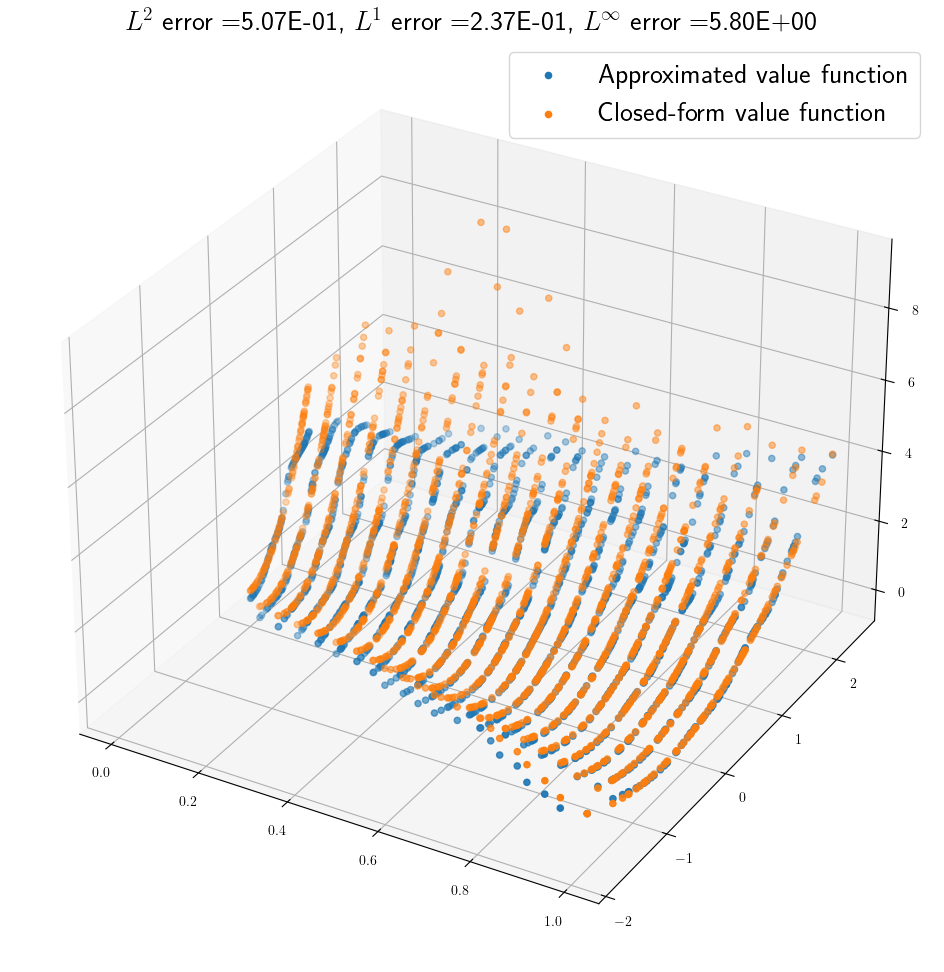

In [27]:
xyz = torch.concat((lqsc.path,lqsc(lqsc.path).unsqueeze(-1)),dim=1).clone().detach().numpy()

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2],label='Approximated value function')
ax.scatter(xyz[:,0], xyz[:,1], solution(xyz[:,0:2]),label='Closed-form value function')
ax.set_title(r"$L^2$ error ={:.2E}, $L^1$ error ={:.2E},  $L^\infty$ error ={:.2E}".format(np.sqrt(np.mean(np.power(solution(xyz[:,0:2])-xyz[:,2],2))),
                                                                                           np.mean(np.abs(solution(xyz[:,0:2])-xyz[:,2])),
                                                                                           np.max(np.abs(solution(xyz[:,0:2])-xyz[:,2]))
                                                                                           ), fontsize=20)
# ax.view_init(elev=30, azim=45, roll=0)
ax.legend(prop=font);
display(Markdown(r"Relative $L^1$ error $= {:.2f}\%$".format(np.mean(np.abs(solution(xyz[:,0:2])-xyz[:,2]))/np.mean(np.abs(solution(xyz[:,0:2])))*100)))
display(Markdown(r"Relative $L^2$ error $= {:.2f}\%$".format(np.sqrt(np.mean(np.power(solution(xyz[:,0:2])-xyz[:,2],2)))/np.sqrt(np.mean(np.power(solution(xyz[:,0:2]),2)))*100)))
display(Markdown(r"Relative $L^\infty$ error $= {:.2f}\%$".format(np.max(np.abs(solution(xyz[:,0:2])-xyz[:,2]))/np.max(np.abs(solution(xyz[:,0:2])))*100)))

In [28]:
lqsc.cost_eval(lqsc.policy,100)
qpoint = (lqsc.x1 - lqsc.x0)/4.
t = torch.zeros([100,1])
sum = 0
for i in range(100):
    x=torch.FloatTensor(100,1).uniform_(lqsc.x0+qpoint,lqsc.x1-qpoint)
    tx = torch.concat((t,x),dim=1)
    sum += np.mean(np.abs(lqsc.value0(x).squeeze(-1).clone().detach().numpy()-solution(tx)))/np.mean(np.abs(solution(tx)))
display(Markdown(r"${:.2f}\%$".format(sum)))

Initial value function training time= 0.9902791976928711


$9.09\%$

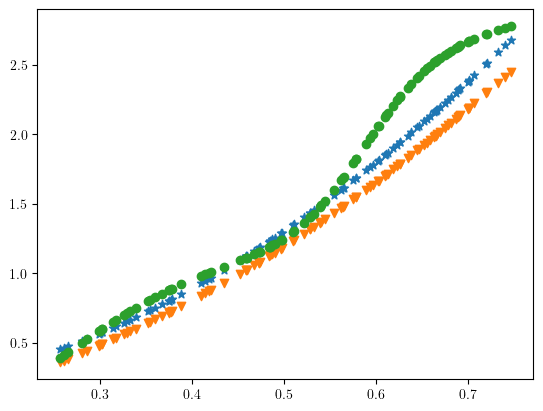

In [29]:
plt.scatter(x=x.clone().detach().numpy(),y = solution(tx),marker='*');
plt.scatter(x=x.clone().detach().numpy(),y = lqsc.value0(x).squeeze(-1).clone().detach().numpy(),marker='v');
plt.scatter(x=x.clone().detach().numpy(),y = lqsc.value(tx).squeeze(-1).clone().detach().numpy(),marker='o');

<!-- # Multi-scale PGM -->

# Multi-scale PGM

## Multi-scale parameters

In [252]:
ms1_model_params = {
    'num_samples':200,
    'num_time_steps':5,
    'num_neurons_p':50,
    'num_neurons_v':10,
    'lr' : 8e-3,
    'num_epochs' : 3000,
    'xmin' : 0.,
    'xmax' : 1.,
    'intervals' : [[0,1./5.],[3./5.,4./5.], [4./5.,1.]], # a list of numbers between 0 to num_intervals-1
    'data': lqsc.path
    }
# ms1_lqsc_params = {
#     'T': np.round(lqsc.delta.clone().detach().numpy(),5),
#     'a':0.1,
#     'b':0.1,
#     'c':0.1,
#     'd':0.1,
#     'A':0.1,
#     'B':0.1,
#     'sigma':0.01,
#     'alpha':0.1,
#     'beta':0.1,
#     'gamma':0.0
#     }

## Multi-scale class

In [253]:
class multi_scale_pgm(object):
    def __init__(self, model_params, lqsc_params, parent):
        self.num_samples = model_params['num_samples']
        self.num_time_steps = model_params['num_time_steps']
        self.num_neurons_p = model_params['num_neurons_p']
        self.num_neurons_v = model_params['num_neurons_v']
        self.lr = model_params['lr']
        self.num_epochs = model_params['num_epochs']
        self.x0 = model_params['xmin']
        self.x1 = model_params['xmax']
        self.intervals = [[0,1.]] if model_params['intervals']== None else model_params['intervals']
        self.num_intervals = len(self.intervals)
        self.T = parent.delta
        self.delta = parent.delta/self.num_time_steps
        self.a=lqsc_params['a']
        self.b=lqsc_params['b']
        self.c=lqsc_params['c']
        self.d=lqsc_params['d']
        self.A=lqsc_params['A']
        self.B=lqsc_params['B']
        self.sigma=lqsc_params['sigma']
        self.alpha=lqsc_params['alpha']
        self.beta=lqsc_params['beta']
        self.gamma=lqsc_params['gamma']
        self.parent = parent#lambda tx: self.alpha*torch.pow(tx[:,1],2)+self.beta*tx[:,1]+self.gamma
        self.init_data = model_params['data']


        self.model= torch.nn.Sequential(
            torch.nn.Linear(2, self.num_neurons_p),
            torch.nn.ReLU(),
            torch.nn.Linear(self.num_neurons_p, self.num_neurons_p),
            torch.nn.ReLU(),
            torch.nn.Linear(self.num_neurons_p,1)
        )
        self.value= torch.nn.Sequential(
            torch.nn.Linear(2, self.num_neurons_v),
            torch.nn.Tanh(),
            torch.nn.Linear(self.num_neurons_v, self.num_neurons_v),
            torch.nn.Tanh(),
            torch.nn.Linear(self.num_neurons_v,1)
        )
        
        self.value0= torch.nn.Sequential(
            torch.nn.Linear(1, self.num_neurons_p),
            torch.nn.ReLU(),
            torch.nn.Linear(self.num_neurons_p, self.num_neurons_p),
            torch.nn.ReLU(),
            torch.nn.Linear(self.num_neurons_p,1)
        )
    def gen_data(self):
        if self.intervals == [[0,1.]]:
            self.t=torch.zeros([self.num_samples,self.num_intervals])
            #z=np.zeros([M,ite+1])+np.random.rand(M,1)
            self.z= torch.normal(0, 1, size=(self.num_samples,self.num_time_steps+1))
            self.x_train=torch.FloatTensor(self.num_samples,1).uniform_(self.x0,self.x1)   #remaining balance R_t   #To get a positive solution R_t has to be greater than D_t
            self.data=torch.cat((self.t,self.x_train),dim=1)
        else:
            x = self.init_data
            for i,I in enumerate(self.intervals):
                if i==0:
                    data = x[torch.abs(x[:,0]-I[0])<1e-2]
                    indices = random.choices(range(data.shape[0]),k=self.num_samples)
                    self.data = data[indices,:]
                else:
                    data = x[torch.abs(x[:,0]-I[0])<1e-2]
                    indices = random.choices(range(data.shape[0]),k=self.num_samples)
                    data = data[indices,:]
                    self.data = torch.concat((self.data,data))
        self.z= torch.normal(0, 1, size=(self.data.shape[0],self.num_time_steps+1))

    
    def update(self,x3,psi,i):
        t=(x3[:,0]+self.delta)
        x=x3[:,1]+(self.c*x3[:,1]+self.d*psi)*self.delta+self.sigma*torch.sqrt(self.delta)*self.z[:,i]
        up=torch.cat((t.unsqueeze(1),x.unsqueeze(1)),dim=1)
        return up

    def loss_func(self,x2,psi):
        loss=self.a*torch.pow(x2[:,1],2)+self.b*x2[:,1]+self.A*torch.pow(psi,2)+self.B*psi
        return loss

    def loss_func_ter(self,x4):
        # loss=self.alpha*torch.pow(x4[:,1],2)+self.beta*x4[:,1]
        return self.parent(x4)#loss

    def unit(self,x1,i,policy):
        psi=policy(x1).squeeze(1)
        loss=self.loss_func(x1,psi)
        upd=self.update(x1,psi,i)
        #print('unit print=',psi.shape,los.shape,upd.shape)
        return psi,loss,upd

    def loss_func_total(self,epoch):
        u = self.data
        path = torch.zeros(self.num_samples*self.num_intervals,self.num_time_steps+1,2)
        path_loss=torch.zeros(self.num_samples*self.num_intervals,self.num_time_steps+1)# (i,j)-> (i+1)j
        psi=torch.zeros(self.num_samples*self.num_intervals,self.num_time_steps)
        if (epoch==self.num_epochs-1):
            self.state_var=u.clone().detach()   
            path[:,0,:] = u.clone().detach()
        for i in range(self.num_time_steps):
            psi_run,loss_run,u_run=self.unit(u,i,self.model)
            #print('los func=',psi_run.shape,loss_run.shape)
            path_loss[:,i]=loss_run*self.delta
            #print(loss)
            psi[:,i]=psi_run
            #print(psi)
            u=u_run
            if (epoch==self.num_epochs-1):
                self.state_var = torch.concat((self.state_var,u.clone().detach()), axis=0)  
                path[:,i+1,:] = u.clone().detach()     
        path_loss[:,-1]=self.loss_func_ter(u)
        if (epoch==self.num_epochs-1):
            a = torch.flip(path_loss, dims = (1,))
            b = torch.cumsum(a, dim=1)
            c = torch.flip(b, dims = (1,))
            d = torch.transpose(c,0,1)
            self.path_cost = d.reshape(self.num_intervals*(self.num_time_steps+1)*self.num_samples,1).clone().detach()
            p = torch.transpose(path,0,1)
            self.path = p.reshape(self.num_intervals*(self.num_time_steps+1)*self.num_samples,2).clone().detach()            
        loss_=torch.sum(path_loss,dim=1)
        return loss_
    
    def train_it(self):
        self.gen_data()
        start=time.time()
        cost_ar=[]
        optimizer = optim.Adam(self.model.parameters(), self.lr)
        for epoch in range(self.num_epochs):
            optimizer.zero_grad()
            cost = self.loss_func_total(epoch)
            loss = torch.mean(cost)
            loss.backward()
            optimizer.step()
            cost_ar.append(loss)
            #print(loss.item())
            if (epoch % 500==0):
                print("At epoch {} the mean cost is {}.".format(epoch,loss.detach()))
        end=time.time()
        total_time=end-start
        print('Training time=',total_time)
        permuted_range = np.random.permutation(self.num_intervals*(self.num_time_steps+1)*self.num_samples)
        tx = self.path[permuted_range,:]
        val = self.path_cost[permuted_range,:]
        optimizer_v = optim.Adam(self.value.parameters(), self.lr)
        start=time.time()
        for epoch in range(self.num_epochs):
            loss_v = torch.nn.MSELoss()(self.value(tx),val)
            optimizer_v.zero_grad()
            loss_v.backward()
            optimizer_v.step()
        end=time.time()
        total_time=end-start
        print('value function training time=',total_time)
        self.path_full, self.path_cost_full = self.optimal_path(self.parent.num_samples)

        
        
    def __call__(self, tx):
        return self.value(tx).squeeze(-1)
    
    def policy(self,tx):
        return self.model(tx)    
        
    def optimal_path(self,num_samples):
        N = self.parent.num_time_steps*self.num_time_steps+1
        path = torch.zeros(num_samples,N,2)
        path_loss=torch.zeros(num_samples,N)
        t=torch.zeros([num_samples,1])
        self.z= torch.normal(0, 1, size=(num_samples,N))
        x=torch.FloatTensor(num_samples,1).uniform_(self.x0,self.x1)   #remaining balance R_t   #To get a positive solution R_t has to be greater than D_t
        path[:,0,:] = torch.cat((t,x),dim=1).clone().detach()
        for i in range(N-1):
            _,loss_run,u_run=self.unit(path[:,i,:],i,self.model)
            path[:,i+1,:] = u_run.clone().detach() 
            path_loss[:,i]=loss_run*self.delta   
        path_loss[:,-1]=self.loss_func_ter(u_run)
        p = torch.transpose(path,0,1)
        path = p.reshape(num_samples*N,2).clone().detach()   
        a = torch.flip(path_loss, dims = (1,))
        b = torch.cumsum(a, dim=1)
        c = torch.flip(b, dims = (1,))
        d = torch.transpose(c,0,1)
        path_cost = d.reshape(num_samples*N,1).clone().detach()         
        return path, path_cost
        
   
    # def cost_eval(self,policy,num_samples):
    #     N = self.parent.num_time_steps*self.num_time_steps+1
    #     path = torch.zeros(num_samples,N,2)
    #     path_loss=torch.zeros(num_samples,N)
    #     t=torch.zeros([num_samples,1])
    #     self.z= torch.normal(0, 1, size=(num_samples,N))
    #     qpoint = (self.x1 - self.x0)/4.
    #     x=torch.FloatTensor(num_samples,1).uniform_(self.x0+qpoint,self.x1-qpoint)   #remaining balance R_t   #To get a positive solution R_t has to be greater than D_t
    #     path[:,0,:] = torch.cat((t,x),dim=1).clone().detach()
    #     for i in range(N-1):
    #         _,loss_run,u_run=self.unit(path[:,i,:],i,policy)
    #         path[:,i+1,:] = u_run.clone().detach() 
    #         path_loss[:,i]=loss_run*self.delta   
    #     path_loss[:,-1]=self.loss_func_ter(u_run)
    #     p = torch.transpose(path,0,1)
    #     path = p.reshape(num_samples*N,2).clone().detach()   
    #     a = torch.flip(path_loss, dims = (1,))
    #     b = torch.cumsum(a, dim=1)
    #     c = torch.flip(b, dims = (1,))
    #     d = torch.transpose(c,0,1)
    #     path_cost = d.reshape(num_samples*N,1).clone().detach()         
    #     return path, path_cost

  
    def cost_eval(self,policy,num_samples):
        N = self.parent.num_time_steps*self.num_time_steps+1
        full_path = torch.zeros(num_samples,N,2)
        full_path_loss=torch.zeros(num_samples,N)
        t=torch.zeros([num_samples,1])
        self.z= torch.normal(0, 1, size=(num_samples,N))
        qpoint = (self.x1 - self.x0)/4.
        x=torch.FloatTensor(num_samples,1).uniform_(self.x0+qpoint,self.x1-qpoint)   #remaining balance R_t   #To get a positive solution R_t has to be greater than D_t
        full_path[:,0,:] = torch.cat((t,x),dim=1).clone().detach()
        for i in range(N-1):
            _,loss_run,u_run=self.unit(full_path[:,i,:],i,policy)
            full_path[:,i+1,:] = u_run.clone().detach() 
            full_path_loss[:,i]=loss_run*self.delta   
        full_path_loss[:,-1]=self.loss_func_ter(u_run)
        val = torch.sum(full_path_loss.clone().detach(),dim=1).unsqueeze(-1).clone().detach()
        p = torch.transpose(full_path,0,1)
        self.full_path = p.reshape(num_samples*N,2).clone().detach()   
        a = torch.flip(full_path_loss, dims = (1,))
        b = torch.cumsum(a, dim=1)
        c = torch.flip(b, dims = (1,))
        d = torch.transpose(c,0,1)
        self.full_path_cost = d.reshape(num_samples*N,1).clone().detach()        
        x = x.clone().detach()
        permuted_range = np.random.permutation(x.shape[0])
        self.test_at_zero(x[permuted_range,:],val[permuted_range,:])
        
    def test_at_zero(self,x,val):
        optimizer_v = optim.Adam(self.value0.parameters(), self.lr)
        start=time.time()
        for _ in range(self.num_epochs):
            loss_v = torch.nn.MSELoss()(self.value0(x),val)
            optimizer_v.zero_grad()
            loss_v.backward()
            optimizer_v.step()
        end=time.time()
        total_time=end-start
        print('Initial value function training time=',total_time)       
         
    

## Instance creation

In [254]:
ms1 = multi_scale_pgm(ms1_model_params,lqsc_params, lqsc)

In [ ]:
ms1.train_it()

In [ ]:
ms1.cost_eval(ms1.policy,100)
qpoint = (ms1.x1 - ms1.x0)/4.
t = torch.zeros([100,1])
sum = 0
for i in range(100):
    x=torch.FloatTensor(100,1).uniform_(ms1.x0+qpoint,ms1.x1-qpoint)
    tx = torch.concat((t,x),dim=1)
    sum += np.mean(np.abs(ms1.value0(x).squeeze(-1).clone().detach().numpy()-solution(tx)))/np.mean(np.abs(solution(tx)))
display(Markdown(r"${:.2f}\%$".format(sum)))

In [ ]:
plt.scatter(x=x.clone().detach().numpy(),y = solution(tx),marker='*');
plt.scatter(x=x.clone().detach().numpy(),y = ms1.value0(x).squeeze(-1).clone().detach().numpy(),marker='v');

In [ ]:
xyz = torch.concat((ms1.path,ms1.value(ms1.path)),dim=1).clone().detach().numpy()

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2],label='approximated value function')
ax.scatter(xyz[:,0], xyz[:,1], solution(xyz[:,0:2]),label='closed-form value function')
ax.set_title(r"$L^2$ error ={:.2E}, $L^1$ error ={:.2E}, $L^\infty$ error ={:.2E}".format(
    np.sqrt(np.mean(np.power(solution(xyz[:,0:2])-xyz[:,2],2))),
    np.mean(np.abs(solution(xyz[:,0:2])-xyz[:,2])),
    np.max(np.abs(solution(xyz[:,0:2])-xyz[:,2]))), fontsize=20)
ax.legend();
display(Markdown(r"Relative $L^1$ error $= {:.2f}\%$".format(np.mean(np.abs(solution(xyz[:,0:2])-xyz[:,2]))/np.mean(np.abs(solution(xyz[:,0:2])))*100)))
display(Markdown(r"Relative $L^2$ error $= {:.2f}\%$".format(np.sqrt(np.mean(np.power(solution(xyz[:,0:2])-xyz[:,2],2)))/np.sqrt(np.mean(np.power(solution(xyz[:,0:2]),2)))*100)))
display(Markdown(r"Relative $L^\infty$ error $= {:.2f}\%$".format(np.max(np.abs(solution(xyz[:,0:2])-xyz[:,2]))/np.max(np.abs(solution(xyz[:,0:2])))*100)))

In [ ]:
xyz = torch.concat((ms1.path_full,ms1.value(ms1.path_full)),dim=1).clone().detach().numpy()

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2],label='approximated value function')
ax.scatter(xyz[:,0], xyz[:,1], solution(xyz[:,0:2]),label='closed-form value function')
ax.legend();
ax.set_title(r"$L^2$ error ={:.2E}, $L^1$ error ={:.2E},, $L^\infty$ error ={:.2E}".format(
    np.sqrt(np.mean(np.power(solution(xyz[:,0:2])-xyz[:,2],2))),
    np.mean(np.abs(solution(xyz[:,0:2])-xyz[:,2])),
    np.max(np.abs(solution(xyz[:,0:2])-xyz[:,2])),
    ), fontsize=20)
plt.tight_layout();
display(Markdown(r"Relative $L^1$ error $= {:.2f}\%$".format(np.mean(np.abs(solution(xyz[:,0:2])-xyz[:,2]))/np.mean(np.abs(solution(xyz[:,0:2])))*100)))
display(Markdown(r"Relative $L^2$ error $= {:.2f}\%$".format(np.sqrt(np.mean(np.power(solution(xyz[:,0:2])-xyz[:,2],2)))/np.sqrt(np.mean(np.power(solution(xyz[:,0:2]),2)))*100)))
display(Markdown(r"Relative $L^\infty$ error $= {:.2f}\%$".format(np.max(np.abs(solution(xyz[:,0:2])-xyz[:,2]))/np.max(np.abs(solution(xyz[:,0:2])))*100)))

In [ ]:
xyz = torch.concat((ms1.path_full,ms1.parent.value(ms1.path_full)),dim=1).clone().detach().numpy()

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2],label='approximated value function')
ax.scatter(xyz[:,0], xyz[:,1], solution(xyz[:,0:2]),label='closed-form value function')
ax.legend();
ax.set_title(r"$L^2$ error ={:.2E}, $L^1$ error ={:.2E},, $L^\infty$ error ={:.2E}".format(
    np.sqrt(np.mean(np.power(solution(xyz[:,0:2])-xyz[:,2],2))),
    np.mean(np.abs(solution(xyz[:,0:2])-xyz[:,2])),
    np.max(np.abs(solution(xyz[:,0:2])-xyz[:,2])),
    ), fontsize=20)
plt.tight_layout();

display(Markdown(r"Relative $L^1$ error $= {:.2f}\%$".format(np.mean(np.abs(solution(xyz[:,0:2])-xyz[:,2]))/np.mean(np.abs(solution(xyz[:,0:2])))*100)))
display(Markdown(r"Relative $L^2$ error $= {:.2f}\%$".format(np.sqrt(np.mean(np.power(solution(xyz[:,0:2])-xyz[:,2],2)))/np.sqrt(np.mean(np.power(solution(xyz[:,0:2]),2)))*100)))
display(Markdown(r"Relative $L^\infty$ error $= {:.2f}\%$".format(np.max(np.abs(solution(xyz[:,0:2])-xyz[:,2]))/np.max(np.abs(solution(xyz[:,0:2])))*100)))

# 50 steps Brute-force

In [274]:
bf_model_params = {
    'num_samples':300,
    'num_time_steps':50,
    'num_neurons_p':50,
    'num_neurons_v':10,
    'lr' : 8e-3,
    'num_epochs' : 3000,
    'xmin' : 0.,
    'xmax' : 1.,
    'intervals' : None # a list of numbers between 0 to num_intervals-1
    }

In [275]:
bf_lqsc = pgm(bf_model_params,lqsc_params, t1)

In [ ]:
bf_lqsc.train_it()

In [ ]:
bf_lqsc.cost_eval(bf_lqsc.policy,1000)
qpoint = (bf_lqsc.x1 - bf_lqsc.x0)/4.
t = torch.zeros([100,1])
sum = 0
for i in range(100):
    x=torch.FloatTensor(100,1).uniform_(bf_lqsc.x0+qpoint,bf_lqsc.x1-qpoint)
    tx = torch.concat((t,x),dim=1)
    sum += np.mean(np.abs(bf_lqsc.value0(x).squeeze(-1).clone().detach().numpy()-solution(tx)))/np.mean(np.abs(solution(tx)))
display(Markdown(r"${:.2f}\%$".format(sum)))

In [ ]:
plt.scatter(x=x.clone().detach().numpy(),y = solution(tx),marker='*');
plt.scatter(x=x.clone().detach().numpy(),y = bf_lqsc.value0(x).squeeze(-1).clone().detach().numpy(),marker='v');